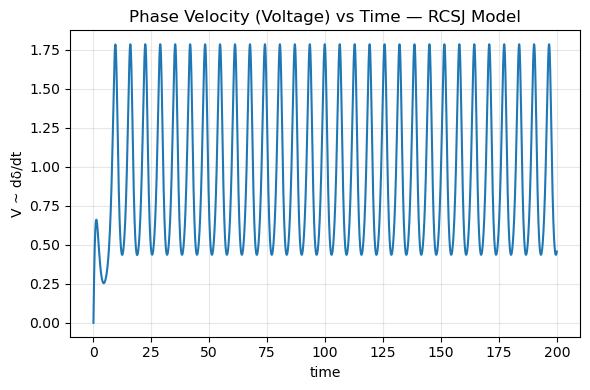

In [149]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.fft import rfft
from scipy.ndimage import gaussian_filter1d

plt.rcParams['font.family'] = ['DejaVu Sans', 'Malgun Gothic']
plt.rcParams['axes.unicode_minus'] = False

# -----------------------------
# RCSJ 모델 정의
# -----------------------------
Ic, R, C = 1.0, 1.0, 1.0
Q = R * np.sqrt(C / Ic)   # 감쇠 인자

def rcsj(t, y, Ib):
    """단일 Josephson Junction의 RCSJ 방정식"""
    δ, dδ = y
    ddδ = Ib - np.sin(δ) - dδ/Q 
    return [dδ, ddδ]

# -----------------------------
# 시간에 따른 Phase Velocity 시뮬레이션
# -----------------------------
t_span = (0, 200)
t_eval = np.linspace(*t_span, 4000)
Ib = 1.2

sol = solve_ivp(rcsj, t_span, [0, 0], args=(Ib,), t_eval=t_eval)
V = sol.y[1]

plt.figure(figsize=(6,4))
plt.plot(sol.t, V)
plt.xlabel('time')
plt.ylabel('V ~ dδ/dt')
plt.title('Phase Velocity (Voltage) vs Time — RCSJ Model')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

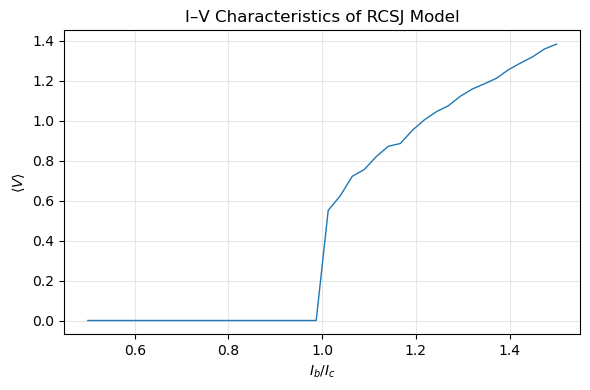

In [141]:
currents = np.linspace(0.5, 1.5, 40)
avg_V = []
avg_window = 0.8 # 평균 낼 때 마지막 20% 구간만 사용

for Ib in currents:
    sol = solve_ivp(rcsj, (0, 500), [0, 0], args=(Ib,), t_eval=np.linspace(0, 500, 3000))
    V = sol.y[1]
    avg_V.append(np.mean(V[int(len(V)*avg_window):])) 

plt.figure(figsize=(6,4))
plt.plot(currents, avg_V, '-', lw=1)
plt.xlabel('$I_b / I_c$')
plt.ylabel('$⟨V⟩$')
plt.title('I–V Characteristics of RCSJ Model')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


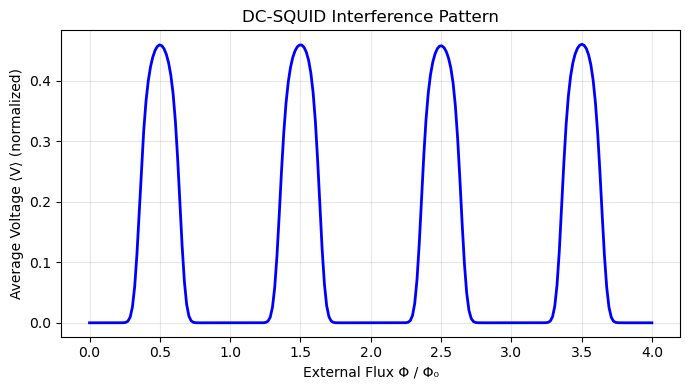

In [142]:
# -----------------------------
# DC-SQUID 모델 정의 및 시뮬레이션
# -----------------------------
Phi0 = 1.0                # 플럭스 양자
Ib_squid = 1.1          # SQUID의 바이어스 전류 (normalized)
Q_squid = 5.0             # 감쇠 인자
alpha_couple = 1        # 두 접합 간의 결합 상수


def squid(t, y, phi_ext):
    δ1, v1, δ2, v2 = y
    coupling = (δ2 - δ1 - 2*np.pi*phi_ext/Phi0)  # 외부 플럭스에 의한 위상 결합항
    dd1 = rcsj(t, [δ1, v1], Ib_squid/2 + alpha_couple*coupling)[1]
    dd2 = rcsj(t, [δ2, v2], Ib_squid/2 - alpha_couple*coupling)[1]
    return [v1, dd1, v2, dd2]  

# -----------------------------
# 외부 플럭스에 따른 전압 평균
# -----------------------------
phi_ext_values = np.linspace(0, 4, 250)
Vavg_squid = []

t_span = (0, 300)              
t_eval = np.linspace(*t_span, 1000) 

# 각 Φ_ext에 대한 SQUID 응답 시뮬레이션
for phi_ext in phi_ext_values:
    sol = solve_ivp(squid, t_span, [0,0,0,0],
                    args=(phi_ext,), method='RK45',
                    t_eval=t_eval, rtol=1e-5, atol=1e-7)
    V = (sol.y[1] + sol.y[3]) / 2        # 두 접합의 평균 전압 (V ~ δ_dot)
    Vavg_squid.append(np.mean(V[int(len(V)*avg_window):]))  # 수렴 후 평균 전압

# -----------------------------
# 결과 처리 및 시각화
# -----------------------------
Vavg_squid = np.array(Vavg_squid)
Vavg_smooth = gaussian_filter1d(Vavg_squid, sigma=2)  # 가우시안 필터로 평활화

plt.figure(figsize=(7,4))
plt.plot(phi_ext_values, Vavg_smooth, 'b-', lw=2)
plt.xlabel('External Flux Φ / Φ₀')
plt.ylabel('Average Voltage ⟨V⟩ (normalized)')
plt.title('DC-SQUID Interference Pattern')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

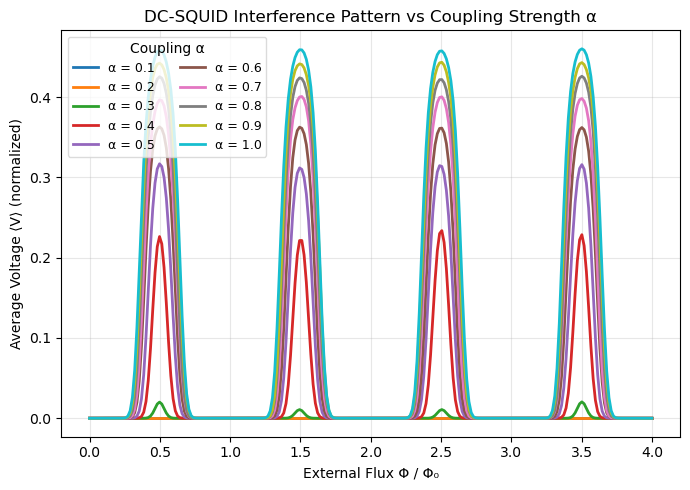

In [143]:
# -----------------------------
# α Sweep 시뮬레이션 (전역 alpha_couple 사용)
# -----------------------------
alpha_values = np.linspace(0.1, 1.0, 10)
plt.figure(figsize=(7,5))

for α in alpha_values:
    alpha_couple = α        # 루프 돌 때마다 전역 alpha값 갱신
    Vavg_squid = []

    for phi_ext in phi_ext_values:
        sol = solve_ivp(
            squid,                   # 이미 정의된 함수 그대로 사용
            t_span, [0,0,0,0],
            args=(phi_ext,),          # phi_ext만 전달
            t_eval=t_eval, rtol=1e-5, atol=1e-7
        )
        V = (sol.y[1] + sol.y[3]) / 2
        Vavg_squid.append(np.mean(V[int(len(V)*avg_window):]))

    Vavg_smooth = gaussian_filter1d(Vavg_squid, sigma=2)
    plt.plot(phi_ext_values, Vavg_smooth, lw=2, label=f'α = {α:.1f}')

plt.xlabel('External Flux Φ / Φ₀')
plt.ylabel('Average Voltage ⟨V⟩ (normalized)')
plt.title('DC-SQUID Interference Pattern vs Coupling Strength α')
plt.grid(True, alpha=0.3)
plt.legend(
    title='Coupling α',
    ncol=2, fontsize=9, title_fontsize=10,
    frameon=True, facecolor='white', edgecolor='lightgray', loc='upper left')
plt.tight_layout()
plt.show()

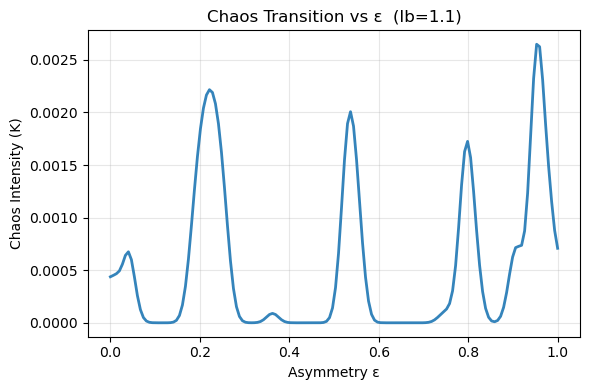

In [ ]:
# -----------------------------
# ε sweep : chaos transition
# -----------------------------
def run_eps_sweep(phi_ext=1.0, Ib=1.1, n_points=150):
    eps_values = np.linspace(0, 1, n_points)
    K_list = []

    for eps in eps_values:
        sol = solve_ivp(
            squid_eps, (0, 800), [0, 0, 0, 0],  
            args=(phi_ext, eps, Ib),
            t_eval=np.linspace(0, 800, 1800),
            rtol=1e-6, atol=1e-8
        )
        V = (sol.y[1] + sol.y[3]) / 2
        K_list.append(kstat_01(V))

    K_smooth = gaussian_filter1d(K_list, sigma=2)

    plt.figure(figsize=(6,4))
    plt.plot(eps_values, K_smooth, '-', lw=2.0, alpha=0.9)
    plt.xlabel('Asymmetry ε')
    plt.ylabel('Chaos Intensity (K)')
    plt.title(f'Chaos Transition vs ε  (Ib={Ib})')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

run_eps_sweep()


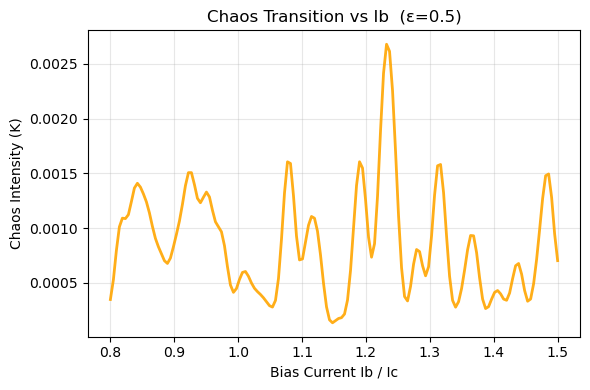

In [151]:
# -----------------------------
# Ib sweep : chaos transition
# -----------------------------
def run_Ib_sweep(phi_ext=1.0, eps=0.5, n_points=150):
    Ib_values = np.linspace(0.8, 1.5, n_points)
    K_list = []

    for Ib in Ib_values:
        sol = solve_ivp(
            squid_eps, (0, 800), [0, 0, 0, 0],
            args=(phi_ext, eps, Ib),
            t_eval=np.linspace(0, 800, 1800),
            rtol=1e-6, atol=1e-8
        )
        V = (sol.y[1] + sol.y[3]) / 2
        K_list.append(kstat_01(V))

    K_smooth = gaussian_filter1d(K_list, sigma=2)

    plt.figure(figsize=(6,4))
    plt.plot(Ib_values, K_smooth, '-', lw=2.0, alpha=0.9, color='orange')
    plt.xlabel('Bias Current Ib / Ic')
    plt.ylabel('Chaos Intensity (K)')
    plt.title(f'Chaos Transition vs Ib  (ε={eps})')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

run_Ib_sweep()